## S-Mobile: Predicting Customer Churn
* Team-lead GitLab id: panaya
* Group name:
* Team member names: Paige, Perla, Michael, Aneeta

## Setup

Please complete this Jupyter notebook by answering the questions in `s-mobile.pdf` on Canvas (week9/). Create a Notebook and HTML file with all your results and comments and push both the Notebook and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML from the Jupyter Notebook file without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the fourth group assignment for MGTA 455 and you will be using git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". git will not decide for you who's change to accept so the team-lead will have to determine which edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import os
import urllib.request
import zipfile
from tempfile import NamedTemporaryFile as tmpfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import qgrid

import xgboost as xgb
import seaborn as sns

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [3]:
## load the data - this dataset must NOT be changed
s_mobile = pd.read_pickle("data/s_mobile.pkl")
s_mobile["churn_yes"] = rsm.ifelse(s_mobile["churn"] == "yes", 1, 0)

If you want access to the full 1M row dataset, use the code below to download and use the data. Please do **not** include the 1M row dataset in your repo!

The downside to using the dataset with 1M rows is, of course, that estimation time will increase substantially. I do NOT recommend you use this dataset to select your final model or for tuning hyper parameters. You can, however, use this larger dataset to re-estimate your chosen model and generate profit estimates for the representative sample.

In [47]:
## uncomment to run
# url = "https://www.dropbox.com/s/xhiexneeok9gyhs/s_mobile_1M.pkl.zip?dl=1"
# file_path, _ = urllib.request.urlretrieve(url)
# zip_file = zipfile.ZipFile(file_path, "r")
# s_mobile_tmp = zip_file.open(zip_file.namelist()[0])
# os.remove(file_path)
# s_mobile = pd.read_pickle(s_mobile_tmp)

In [48]:
# show dataset description
rsm.describe(s_mobile)

## S-mobile

Dataset used to investigate opportunities to decrease customer churn at S-mobile. The sample consists of three parts:

1. A training sample with 27,300 observations and a 50% churn rate ("training == 1")
2. A test sample with 11,700 observations and a 50% churn rate ("training == 0")
3. A representative sample with 30,000 observations and a churn rate of 2%, i.e., the actual monthly churn rate for S-mobile ("is.na(training)" or "representative == 1")

## Variables

* customer: Customer ID
* churn: Did consumer churn in the last 30 days? (yes or no)
* changer: % change in revenue over the most recent 4 month period
* changem: % change in minutes of use over the most recent 4 month period
* revenue: Mean monthly revenue in SGD
* mou: Mean monthly minutes of use
* overage: Mean monthly overage minutes
* roam: Mean number of roaming calls
* conference: Mean number of conference calls
* months: # of months the customer has had service with S-Mobile
* uniqsubs: Number of individuals listed on the customer account
* custcare: Mean number of calls to customer care 
* retcalls: Number of calls by the customer to the retention team
* dropvce: Mean number of dropped voice calls 
* eqpdays: Number of days customer has owned current handset
* refurb: Handset is refurbished (no or yes)
* smartphone: Handset is a smartphone (no or yes)
* creditr: High credit rating as opposed to medium or low (no or yes)
* mcycle: Subscriber owns a motorcycle (no or yes)
* car: Subscriber owns a car (no or yes)
* travel: Subscriber has traveled internationally (no or yes)
* region: Regions delineated by the 5 Community Development Council Districts (e.g., CS is Central Singapore)
* occupation: Categorical variable with 4 occupation levels (professional, student, retired, or other)
* training: 1 for training sample, 0 for test sample, NA for representative sample
* representative: 1 for representative sample, 0 for training and test sample


Use `smf.glm` with `freq_weights` and `cov_type` like in the below example
    
```python
lr = smf.glm(
    formula="churn_yes ~ changer + changem + ...",
    family=Binomial(link=logit()),
    data=pentathlon_nptb.query("training == 1"),
    freq_weights=s_mobile.loc[mobile.training == 1, "cweight"],
).fit(cov_type="HC1")
```

In [49]:
# run python code from another notebook
%run ./sub-notebooks/model1.ipynb

     index     OR   OR%  2.5%  97.5% p.values    
1  changer  1.001  0.1%   1.0  1.002    0.006  **


In [50]:
# importing functions from a module/package
from utils import functions

functions.example()


You just accessed a function from your first python packages!
Change the code in utils/function.py to whatever you need for this assignment
Use 'from utils import functions' to get access to your code
You can add modules to import from by adding additional .py files to the 'utils' directory
Note: If you make changes to the content of this file you will have to restart the notebook kernel to get the updates



## Question answers

1. Develop a model to predict customer churn

### Investigate Data

In [4]:
qgrid.show_grid(s_mobile)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [5]:
pd.get_dummies(
    s_mobile.loc[s_mobile.training == 1, "churn":],
).agg(["mean", "std", "min", "max"]).T

,mean,std,min,max
changer,8.661245,28.956823,-62.0,305.0
changem,15.211392,51.885577,-78.0,521.0
revenue,57.211136,43.258950,0.0,856.0
mou,515.322308,525.458925,0.0,7668.0
overage,66.274286,69.258068,0.0,283.0
roam,1.197253,7.254327,0.0,692.0
conference,0.263480,1.083898,0.0,56.0
months,18.781502,9.595614,6.0,61.0
uniqsubs,1.546227,0.891051,1.0,18.0
custcare,2.288132,4.192970,0.0,32.0


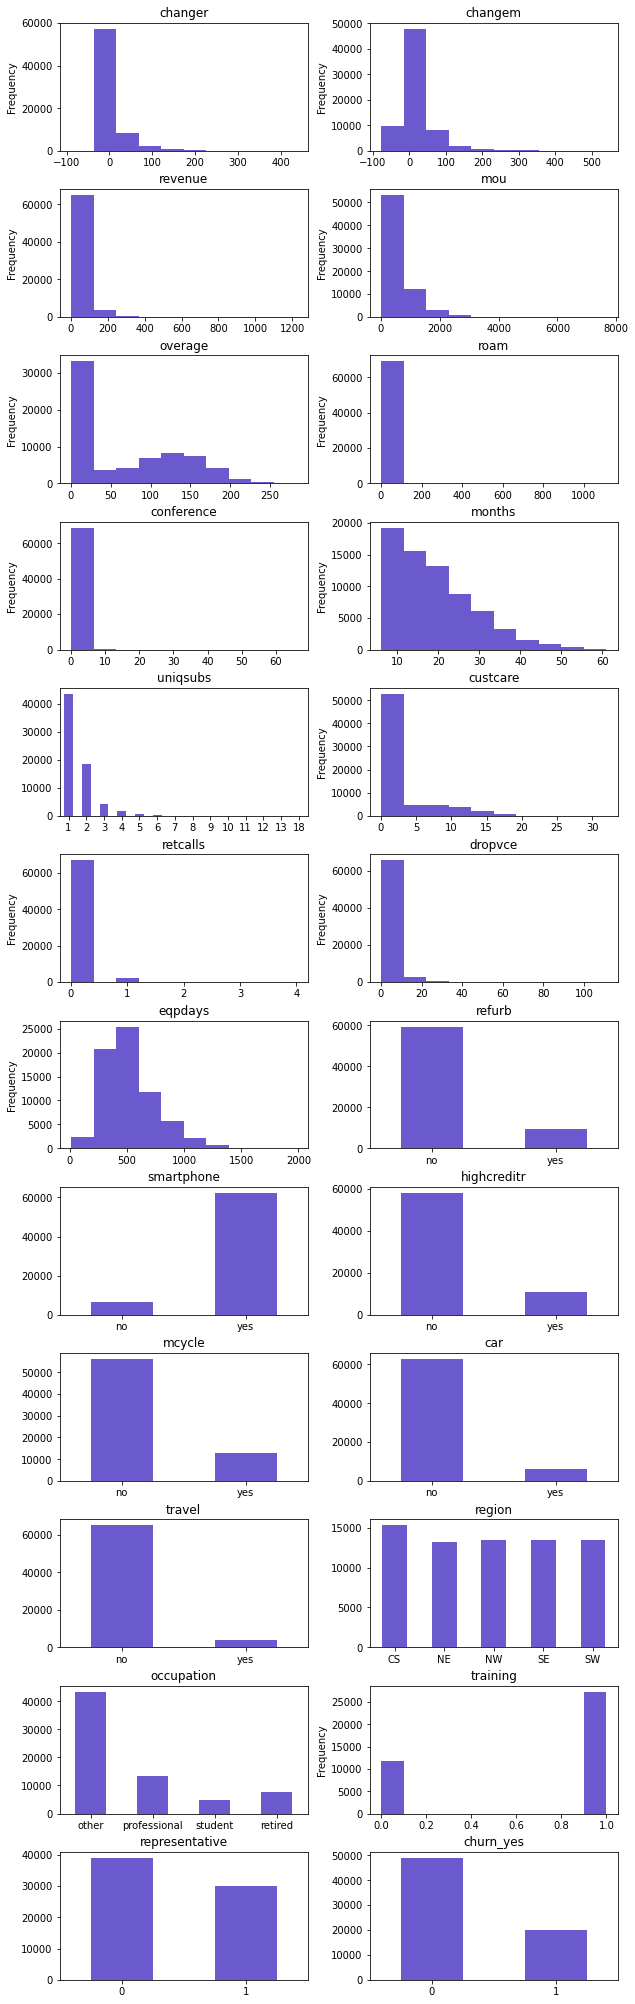

In [6]:
rsm.distr_plot(s_mobile.loc[:,"changer":])

In [7]:
# association between customer care calls and churn?
ct = rsm.cross_tabs(s_mobile.query("training == 1"), "churn", "custcare")
ct.summary(output = "perc_col")


Cross-tabs
Variables: churn, custcare
Null hyp: there is no association between churn and custcare
Alt. hyp: there is an association between churn and custcare

Column percentages:

custcare       0       1       2       3       4       5       6       7  \
churn                                                                      
yes       52.02%  48.91%  46.14%  48.39%  47.95%  45.02%  42.03%  46.22%   
no        47.98%  51.09%  53.86%  51.61%  52.05%  54.98%  57.97%  53.78%   
Total     100.0%  100.0%  100.0%  100.0%  100.0%  100.0%  100.0%  100.0%   

custcare       8       9  ...      22      23      24      26      27      28  \
churn                     ...                                                   
yes       47.38%  43.59%  ...   37.5%  33.33%   25.0%    0.0%  100.0%  100.0%   
no        52.62%  56.41%  ...   62.5%  66.67%   75.0%  100.0%    0.0%    0.0%   
Total     100.0%  100.0%  ...  100.0%  100.0%  100.0%  100.0%  100.0%  100.0%   

custcare      29      31      

In [6]:
# association between customer changem and churn?
ct = rsm.cross_tabs(s_mobile.query("training == 1"), "churn", "changem")
ct.summary(output = "perc_col")


Cross-tabs
Variables: churn, changem
Null hyp: there is no association between churn and changem
Alt. hyp: there is an association between churn and changem

Column percentages:

changem     -78     -77     -76     -75     -74     -73     -72     -71  \
churn                                                                     
yes      33.33%  100.0%  100.0%  66.67%  100.0%  33.33%  33.33%  57.14%   
no       66.67%    0.0%    0.0%  33.33%    0.0%  66.67%  66.67%  42.86%   
Total    100.0%  100.0%  100.0%  100.0%  100.0%  100.0%  100.0%  100.0%   

changem     -70     -69  ...     493     497     501     508     513     514  \
churn                    ...                                                   
yes      44.44%   50.0%  ...    0.0%  100.0%    0.0%  100.0%  100.0%    0.0%   
no       55.56%   50.0%  ...  100.0%    0.0%  100.0%    0.0%    0.0%  100.0%   
Total    100.0%  100.0%  ...  100.0%  100.0%  100.0%  100.0%  100.0%  100.0%   

changem     517     520     521   Total  
c

In [7]:
# association between dropped calls and churn?
ct = rsm.cross_tabs(s_mobile.query("training == 1"), "churn", "dropvce")
ct.summary(output = "perc_col")


Cross-tabs
Variables: churn, dropvce
Null hyp: there is no association between churn and dropvce
Alt. hyp: there is an association between churn and dropvce

Column percentages:

dropvce       0       1       2       3       4       5       6       7  \
churn                                                                     
yes      51.91%  49.85%  48.35%  51.18%  49.65%   48.6%  47.92%  44.79%   
no       48.09%  50.15%  51.65%  48.82%  50.35%   51.4%  52.08%  55.21%   
Total    100.0%  100.0%  100.0%  100.0%  100.0%  100.0%  100.0%  100.0%   

dropvce       8       9  ...      51      52      53      54      56      60  \
churn                    ...                                                   
yes      50.34%  54.52%  ...    0.0%  100.0%  100.0%  100.0%    0.0%    0.0%   
no       49.66%  45.48%  ...  100.0%    0.0%    0.0%    0.0%  100.0%  100.0%   
Total    100.0%  100.0%  ...  100.0%  100.0%  100.0%  100.0%  100.0%  100.0%   

dropvce      62      65      67   Total  
c

### Logistic Regression

In [8]:
#create weights for s_mobile
class_weight_dict = {0: 49, 1: 1}

s_mobile["cweight"] = rsm.ifelse(
    s_mobile.churn == "yes", class_weight_dict[1], class_weight_dict[0]
)

In [9]:
#set id, response variable, and explanatory variables
idvar = "customer"
rvar = "churn_yes"
evar = ['changer', 'changem',
    'revenue','mou',
    'overage','roam', 
    'conference', 'months', 
    'uniqsubs', 'custcare', 
    'retcalls','dropvce', 
    'eqpdays', 'refurb', 
    'smartphone', 'highcreditr',
    'mcycle', 'car', 
    'travel', 'region', 'occupation'
]

In [10]:
form = "churn_yes ~ " + " + ".join(evar)
lr = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"],
    data=s_mobile[s_mobile.training == 1],
).fit(cov_type="HC1")
rsm.or_ci(lr)

,index,OR,OR%,2.5%,97.5%,p.values,
1,refurb[T.yes],1.318,31.8%,1.255,1.385,< .001,***
2,smartphone[T.yes],0.913,-8.7%,0.860,0.969,0.003,**
3,highcreditr[T.yes],0.483,-51.7%,0.455,0.513,< .001,***
4,mcycle[T.yes],0.883,-11.7%,0.834,0.934,< .001,***
5,car[T.yes],0.991,-0.9%,0.919,1.068,0.809,
6,travel[T.yes],0.781,-21.9%,0.723,0.844,< .001,***
7,region[T.NE],0.644,-35.6%,0.611,0.678,< .001,***
8,region[T.NW],0.660,-34.0%,0.627,0.695,< .001,***
9,region[T.SE],0.651,-34.9%,0.618,0.685,< .001,***
10,region[T.SW],0.627,-37.3%,0.595,0.660,< .001,***


In [11]:
rsm.model_fit(lr)


Pseudo R-squared (McFadden): 0.047
Pseudo R-squared (McFadden adjusted): 0.046
Area under the RO Curve (AUC): 0.688
Log-likelihood: -63795.467, AIC: 127644.935, BIC: 127953.64
Chi-squared: 691107.451 df(26), p.value < 0.001 
Nr obs: 27,300



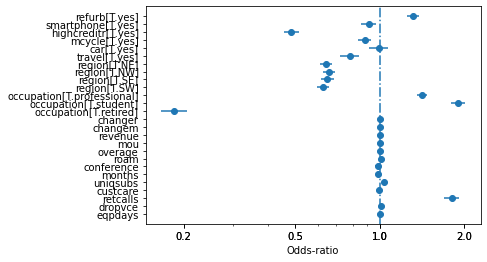

In [12]:
fig = rsm.or_plot(lr)

In [13]:
s_mobile['pred_lr'] = lr.predict(s_mobile)

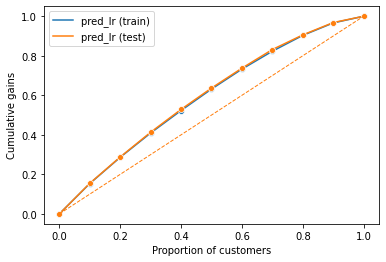

In [14]:
#compare to test data
dct = {"train": s_mobile[s_mobile.training == 1], "test": s_mobile[s_mobile.training == 0]}
fig = rsm.gains_plot(dct, "churn", "yes", "pred_lr").legend(title=None)

In [15]:
#check if predicted churn is similar to 2%
s_mobile[s_mobile.representative == 1].pred_lr.mean().round(3)

0.02

In [10]:
#try a logistic regression with interactions
form = "churn_yes ~ changer + changem +\
        revenue + mou + overage + roam + conference +\
        months + uniqsubs + custcare + retcalls + dropvce +\
        eqpdays + refurb + smartphone + highcreditr + mcycle +\
        car + travel + region + occupation +\
        revenue:occupation + refurb:occupation +\
        uniqsubs:custcare + changer:custcare + retcalls:changem +\
        retcalls:overage + roam:months +\
        dropvce:retcalls + overage:occupation + mou:occupation"
lr1 = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"],
    data=s_mobile[s_mobile.training == 1],
).fit(cov_type="HC1")
rsm.or_ci(lr1)

,index,OR,OR%,2.5%,97.5%,p.values,
1,refurb[T.yes],1.304,30.4%,1.227,1.386,< .001,***
2,smartphone[T.yes],0.914,-8.6%,0.861,0.970,0.003,**
3,highcreditr[T.yes],0.487,-51.3%,0.459,0.518,< .001,***
4,mcycle[T.yes],0.880,-12.0%,0.831,0.931,< .001,***
5,car[T.yes],0.983,-1.7%,0.912,1.061,0.665,
6,travel[T.yes],0.779,-22.1%,0.720,0.842,< .001,***
7,region[T.NE],0.645,-35.5%,0.612,0.679,< .001,***
8,region[T.NW],0.661,-33.9%,0.628,0.696,< .001,***
9,region[T.SE],0.650,-35.0%,0.617,0.684,< .001,***
10,region[T.SW],0.629,-37.1%,0.598,0.663,< .001,***


In [11]:
rsm.model_fit(lr1)


Pseudo R-squared (McFadden): 0.048
Pseudo R-squared (McFadden adjusted): 0.047
Area under the RO Curve (AUC): 0.689
Log-likelihood: -63705.14, AIC: 127500.279, BIC: 128014.788
Chi-squared: 692836.581 df(44), p.value < 0.001 
Nr obs: 27,300



In [12]:
s_mobile['pred_lr1'] = lr1.predict(s_mobile)

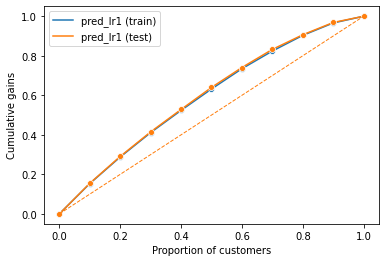

In [13]:
#compare to test data
dct = {"train": s_mobile[s_mobile.training == 1], "test": s_mobile[s_mobile.training == 0]}
fig = rsm.gains_plot(dct, "churn", "yes", "pred_lr1").legend(title=None)

In [14]:
s_mobile[s_mobile.representative == 1].pred_lr1.mean().round(3)

0.02

In [15]:
#standardize data for logistic regression
Xs = rsm.scale_df(
    s_mobile,
    excl = ['customer','churn','refurb','smartphone','credit','mcycle',
           'car','travel','region','occupation','training','representative',
            'cweight', 'pred_lr', 'pred_lr1'],
    wt=s_mobile.cweight,
    train=s_mobile.training == 1,
)
Xs["churn_yes"] = s_mobile.churn_yes
Xs

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,mcycle,car,travel,region,occupation,training,representative,churn_yes,cweight,pred_lr1
0,U86940794,yes,1.795996,0.648059,0.059201,0.051482,0.583946,-0.090861,-0.126390,-0.534447,...,no,no,no,CS,other,0.0,0,1,1,0.038704
1,U56788559,no,-0.146109,-0.134122,-0.032648,-0.364217,-0.453367,-0.090861,-0.126390,-0.534447,...,no,no,no,SE,other,0.0,0,0,49,0.008043
2,U47928407,no,-0.146109,-0.254458,-0.204864,0.562407,0.252889,-0.090861,0.310452,-0.483883,...,yes,no,yes,NW,professional,NaN,1,0,49,0.019963
3,U75794640,no,-0.146109,-0.244430,-0.250789,0.014857,-0.453367,-0.090861,-0.126390,0.931900,...,yes,no,no,NW,retired,1.0,0,0,49,0.000876
4,U41010771,no,-0.181744,-0.244430,0.495484,1.230822,0.370598,0.675463,-0.126390,0.072318,...,yes,yes,no,SW,other,NaN,1,0,49,0.010046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68995,U97081813,no,-0.146109,-0.314625,-0.273751,-0.453034,-0.453367,-0.090861,-0.126390,0.021754,...,yes,yes,no,SW,other,NaN,1,0,49,0.018219
68996,U24071089,no,-0.146109,0.788450,-0.308194,-0.426480,-0.453367,-0.090861,-0.126390,-0.028810,...,yes,yes,no,SE,other,1.0,0,0,49,0.017042
68997,U52895026,yes,-0.146109,-0.114066,-0.158940,-0.268991,-0.063455,-0.090861,-0.126390,0.325136,...,no,no,no,CS,student,0.0,0,1,1,0.083072
68998,U69840472,yes,-0.199561,-0.455017,-0.181902,-0.234197,-0.453367,-0.090861,-0.126390,0.021754,...,no,no,no,CS,other,1.0,0,1,1,0.030815


In [17]:
lr_std = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"],
    data=Xs[s_mobile.training == 1],
).fit(ov_type="HC1")

In [18]:
(
    rsm.or_ci(lr_std, importance=True, data=s_mobile[s_mobile.training == 1])
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

,index,OR,OR%,2.5%,97.5%,p.values,,dummy,importance,wmean,wstd,min,max
0,occupation[T.retired],0.177,-82.3%,0.152,0.205,< .001,***,True,5.656,0.137,0.344,0.0,1.0
1,highcreditr[T.yes],0.487,-51.3%,0.459,0.517,< .001,***,True,2.052,0.180,0.384,0.0,1.0
2,occupation[T.student],1.883,88.3%,1.758,2.015,< .001,***,True,1.883,0.055,0.227,0.0,1.0
3,eqpdays,1.852,85.2%,1.773,1.935,< .001,***,False,1.852,510.298,222.647,22.0,1982.0
4,overage,1.740,74.0%,1.646,1.838,< .001,***,False,1.740,61.625,67.964,0.0,283.0
5,region[T.SW],0.629,-37.1%,0.598,0.663,< .001,***,True,1.589,0.202,0.401,0.0,1.0
6,mou,0.631,-36.9%,0.582,0.685,< .001,***,False,1.584,543.775,546.068,0.0,7668.0
7,region[T.NE],0.645,-35.5%,0.612,0.679,< .001,***,True,1.551,0.199,0.399,0.0,1.0
8,region[T.SE],0.650,-35.0%,0.617,0.684,< .001,***,True,1.539,0.199,0.399,0.0,1.0
9,region[T.NW],0.661,-33.9%,0.628,0.696,< .001,***,True,1.513,0.199,0.399,0.0,1.0


2. Use the model output from a logistic regression to understand the main drivers of churn and 
report on the key factors that predict customer churn and their relative importance

Given the above, I would say main drivers of churn include occupation, if they have a high credit, eqpdays (the number of days an individual has owned a headset), & overage.

Individuals that state their occupation as retired appear much less likely (83.8%) to churn compared to those who list their occupation as 'other', while individuals who list their occupation as student are 90.8% more likely to churn. Occupation - Retired is also appears as the factor with the highest level of importance.  This logically makes sense as retired individuals potentially have more money or time, while students might be on a budget and less free time.

The next most important factor is if an individual has high credit. High credit indicates an individual will be ~50% less likley to churn compared to those with medium / low credit. 

Eqpdays and overage also play important roles in if a customer will churn.


Note: We cannot change what occupation category a customer is in. Focus on variables like eqpdays, overage, mou, and month that we might be able to influence.

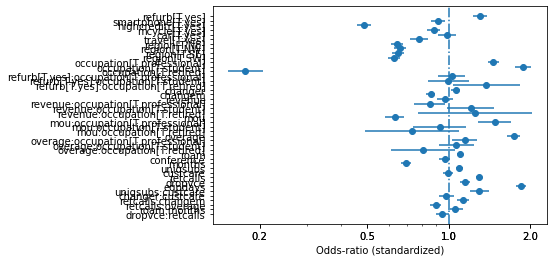

In [24]:
fig = rsm.or_plot(lr_std)
fig = fig.set_xlabel("Odds-ratio (standardized)")

In [25]:
#s_mobile['pred_lrStd'] = lr_std.predict(s_mobile)

In [26]:
#check if predicted churn is similar to 2%
#s_mobile[s_mobile.training == 1].pred_lrStd.mean().round(3)

In [27]:
s_mobile

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,car,travel,region,occupation,training,representative,churn_yes,cweight,pred_lr,pred_lr1
0,U86940794,yes,109,81,62,600,141,0,0,8,...,no,no,CS,other,0.0,0,1,1,0.038733,0.038704
1,U56788559,no,0,3,54,146,0,0,0,8,...,no,no,SE,other,0.0,0,0,49,0.007807,0.008043
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,no,yes,NW,professional,NaN,1,0,49,0.016572,0.019963
3,U75794640,no,0,-8,35,560,0,0,0,37,...,no,no,NW,retired,1.0,0,0,49,0.000876,0.000876
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,yes,no,SW,other,NaN,1,0,49,0.010862,0.010046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68995,U97081813,no,0,-15,33,49,0,0,0,19,...,yes,no,SW,other,NaN,1,0,49,0.017383,0.018219
68996,U24071089,no,0,95,30,78,0,0,0,18,...,yes,no,SE,other,1.0,0,0,49,0.017149,0.017042
68997,U52895026,yes,0,5,43,250,53,0,0,25,...,no,no,CS,student,0.0,0,1,1,0.084279,0.083072
68998,U69840472,yes,-3,-29,41,288,0,0,0,19,...,no,no,CS,other,1.0,0,1,1,0.029511,0.030815


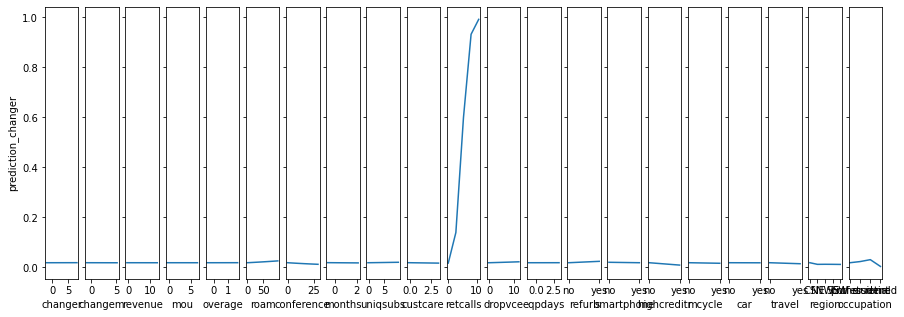

In [28]:
fig, axes = plt.subplots(1, len(evar), sharey=True, figsize=(15, 5))

for i in range(len(evar)):
    idat = rsm.sim_prediction(Xs[evar], vary=evar[i], nnv=50)
    idat[f"prediction_{evar[i]}"] = lr1.predict(idat)
    fig = sns.lineplot(x=evar[i], y=f"prediction_{evar[i]}", data=idat, ax=axes[i])

^ Retcalls = Number of calls by the customer to the retention team

## XGBOOST

In [16]:
X = pd.get_dummies(s_mobile.loc[:, "refurb":"occupation"], drop_first=True)
y = s_mobile.churn_yes

In [ ]:
clf = xgb.XGBClassifier(
    max_depth=4,
    n_estimators=500,
    objective="binary:logistic",
    use_label_encoder=False,
    scale_pos_weight=1 / 49,
    eval_metric="auc",
    random_state=1234,
).fit(X[s_mobile.training == 1], y[s_mobile.training == 1], verbose=True)

In [ ]:
clf.predict_proba(X[s_mobile.training == 0])[:, 1].mean().round(3)


In [ ]:
clf.predict_proba(X[s_mobile.representative == 1])[:, 1].mean().round(3)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance, plot_partial_dependence


def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index
    fig = sns.barplot(
        x="value", y="variable", color="slateblue", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    return fig


In [ ]:
fig = importance(clf, X, y, X.columns)

In [ ]:
fig_cv, ax = plt.subplots(figsize=(14, 14))
ax.set_title("Partial Dependence Plots")
fig = plot_partial_dependence(clf, X, X.columns, ax=ax)
plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 

### Quantify the impact of actions/offers/incentives on the probability of churn

### Eqpdays Analysis

#### Paige

Eqpdays has shown up as one of the most important factors when determining churn. We are investigating further if a promotion could be applied around this variable to help decrease churn.

In [29]:
s_mobile_rep = s_mobile.query("representative == 1").copy()

(array([  406.,  7872., 11298.,  5401.,  3208.,  1152.,   470.,   124.,
           45.,    24.]),
 array([  13. ,  190.3,  367.6,  544.9,  722.2,  899.5, 1076.8, 1254.1,
        1431.4, 1608.7, 1786. ]),
 <BarContainer object of 10 artists>)

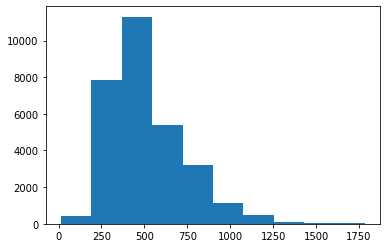

In [30]:
plt.hist(s_mobile_rep.eqpdays)

In [31]:
s_mobile_rep.eqpdays.mean()

509.33886666666666

In [32]:
#investigate eqpdays mean by occupation
s_mobile_rep.groupby('occupation').eqpdays.mean()

occupation
other           487.324261
professional    560.364823
student         512.508464
retired         543.881376
Name: eqpdays, dtype: float64

In [33]:
#investigate eqpdays std by occupation
s_mobile_rep.groupby('occupation').eqpdays.std()

occupation
other           211.929003
professional    239.618259
student         234.587116
retired         238.375099
Name: eqpdays, dtype: float64

In [34]:
#what is churn rate per occupation group when eqpdays > 730 (2 years)
s_mobile_rep[s_mobile_rep.eqpdays > 730].groupby('occupation').churn_yes.mean()

occupation
other           0.023594
professional    0.026405
student         0.079861
retired         0.004614
Name: churn_yes, dtype: float64

In [123]:
#who is most likely to have old equipment?
s_mobile_rep[s_mobile_rep.eqpdays > 730].groupby('occupation').eqpdays.mean()

occupation
other           895.784506
professional    909.528109
student         917.159722
retired         910.693195
Name: eqpdays, dtype: float64

In [35]:
# impact of eliminating equipment age on churn probability
# after 2 years (730 days), offer upgrade 2.4 -> .85
# after 500 days, offer upgrade 2.53 -> .93
# after 1 year (365 days), offer upgrade 2.31 -> .98

s_mobile_rep["p_eqpdaysMin"] = lr1.predict(
    s_mobile[s_mobile.representative == 1].assign(eqpdays=0)
)
s_mobile_rep.loc[s_mobile_rep.eqpdays > 730, ["churn_yes", "p_eqpdaysMin"]].agg(
    ["count", "mean"]
).round(4)

,churn_yes,p_eqpdaysMin
count,4872.0000,4872.0000
mean,0.0242,0.0083


In [36]:
#what is our customer base
s_mobile_rep.occupation.value_counts(normalize=True)

other           0.630767
professional    0.173600
retired         0.140500
student         0.055133
Name: occupation, dtype: float64

After testing a few different values, I selected 730 days (2 years) as the value to use if we implemented this phone upgrade promotion. This will decrease our churn from 2.42% to .83%. We also investigated 500 days, which was close to the mean of eqpdays, but found that the final difference in clv was not much different and figured we should try to maximize the amount of time before extending this offer.

For individuals with eqpdays > 730, the mean churn for professionals is 2.6%, students 7.9%, and other 2.3%, all above the average churn rate of 2%. Even though the retired churn rate in this group is below the 2% churn rate, we have decided to do a standard 2 year upgrade available to all customers & make it a promotion you can expect when signing up for service with S-Mobile. 

### Calculate CLV after implementing upgrade plan

In [24]:
months = np.arange(1,61)
discount = 0.1
mdiscount = (1+discount)**(1/12)-1

In [25]:
#typical churn from above 
churn = pd.Series([.0253]*60)
#what is the average revenue of an individual with a phone greater than eqpdays
avg_revenue = s_mobile_rep[s_mobile_rep.eqpdays > 730].revenue.mean()
prob_active = list((1-churn).cumprod())
prob_active.insert(0, 1)

In [26]:
prob_active = prob_active[:-1]

We need to make assumptions of what sort of cost s-mobile might have, a high fixed cost vs high variable cost. I believe s-mobile would have a high fixed cost. They need to set up a single, large infrastructure, but they are able to charge a variable amount dependent on what plan someone has, how many people are on the plan,etc.

The average revenue across all individuals is ~56, ~47 for individuals with eqpdays > 500. Let's say that the cost to s-mobile is 20 dollars a month.

Assume a monthly discount rate of 8%

In [27]:
expected_profit = np.array(([avg_revenue - 20]*60))*np.array(prob_active)

In [28]:
pv_expected_profit = expected_profit/np.power(1+mdiscount,months)
clv = pv_expected_profit.cumsum()

In [29]:
clv

array([ 22.70380886,  44.65814439,  65.88774741,  86.41654197,
       106.26766242, 125.46347937, 144.025625  , 161.97501737,
       179.33188402, 196.11578476, 212.34563372, 228.03972065,
       243.21573154, 257.89076854, 272.08136927, 285.8035254 ,
       299.07270071, 311.90384851, 324.31142848, 336.30942299,
       347.91135282, 359.13029243, 369.97888467, 380.46935503,
       390.61352546, 400.42282763, 409.90831583, 419.08067947,
       427.95025506, 436.52703793, 444.82069341, 452.8405678 ,
       460.59569887, 468.09482603, 475.3464002 , 482.35859333,
       489.13930761, 495.69618436, 502.03661266, 508.16773768,
       514.09646869, 519.82948693, 525.37325303, 530.73401438,
       535.91781214, 540.93048804, 545.77769095, 550.46488331,
       554.99734719, 559.38019034, 563.61835185, 567.71660781,
       571.67957663, 575.51172425, 579.2173692 , 582.80068745,
       586.26571712, 589.61636301, 592.85640105, 595.98948249])

### Now assume we offer this promotion of an upgrade at the 2 year mark

In [30]:
#typical churn from above 
churn = pd.Series([0.0083]*60)
#what is the average revenue of an individual with a phone greater than eqpdays
avg_revenue = s_mobile_rep[s_mobile_rep.eqpdays < 730].revenue.mean()
prob_active = list((1-churn).cumprod())
prob_active.insert(0, 1)

In [31]:
prob_active = prob_active[:-1]

In [32]:
expected_profit = np.array(([avg_revenue - 20]*60))*np.array(prob_active)

In [33]:
pv_expected_profit = expected_profit/np.power(1+mdiscount,months)
clv = pv_expected_profit.cumsum()

In [34]:
clv

array([  38.99777833,   77.36592213,  115.11459711,  152.25380482,
        188.79338536,  224.74301995,  260.1122335 ,  294.91039713,
        329.14673068,  362.8303051 ,  395.97004491,  428.57473054,
        460.65300065,  492.21335443,  523.26415383,  553.81362582,
        583.86986453,  613.44083339,  642.53436729,  671.1581746 ,
        699.31983924,  727.02682268,  754.28646594,  781.1059915 ,
        807.49250523,  833.45299828,  858.99434891,  884.12332436,
        908.84658258,  933.17067404,  957.10204344,  980.64703143,
       1003.81187629, 1026.60271559, 1049.02558779, 1071.08643387,
       1092.79109887, 1114.1453335 , 1135.15479557, 1155.82505159,
       1176.16157816, 1196.16976348, 1215.85490875, 1235.22222958,
       1254.27685736, 1273.02384066, 1291.46814652, 1309.61466177,
       1327.46819437, 1345.03347464, 1362.31515652, 1379.31781883,
       1396.04596644, 1412.50403151, 1428.69637462, 1444.62728595,
       1460.30098644, 1475.72162884, 1490.89329888, 1505.82001

The CLV of an individual who has a phone over 730 days is 595.99 compared to a CLV of 1505.82 for individuals who have a brand new phone. This means that we should spend no more than 909.83 implementing this plan, which given the price of smartphones this day, seems to fall within a reasonable budget. This would be a one time expenditure. I suggest offering customers a paid for smartphone upgrade, if it is under 872.99, at the 2 year mark. 

## Retcalls Analysis

#### Michael

Retcalls was another variable we thought might be worth looking into. If a customer is calling the customer retention line multiple times, you can assume a churn is inevitable. Can we pinpoint where we should offer some incentive to individuals calling the customer retention team so it will decrease churn?

(array([2.9246e+04, 0.0000e+00, 0.0000e+00, 6.9300e+02, 0.0000e+00,
        0.0000e+00, 5.6000e+01, 0.0000e+00, 0.0000e+00, 5.0000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

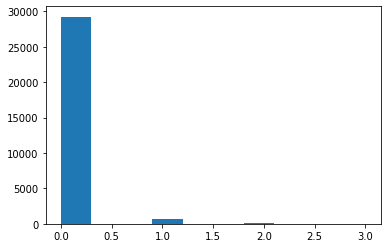

In [67]:
plt.hist(s_mobile_rep.retcalls)

In [68]:
s_mobile_rep.groupby("retcalls").retcalls.count()

retcalls
0.0    29246
1.0      693
2.0       56
3.0        5
Name: retcalls, dtype: int64

In [69]:
s_mobile_rep.groupby("retcalls").churn_yes.mean()

retcalls
0.0    0.019661
1.0    0.027417
2.0    0.107143
3.0    0.000000
Name: churn_yes, dtype: float64

The majority of individuals are NOT calling customer retention. But we notice when it goes from 1 to 2 calls, the churn rate spikes. 

In [40]:
cust_with_retcalls = 30000-29246

After analysis, it is clear that the vast majority of customers did not make a call to the retention team. That being said, of the percentage that did happen to make calls, the churn rate increased significantly from 0.019% for 0 calls to 0.027% for 1 call. Additionally, the number of customers that made 2 retention calls had a churn rate of 10.7%, much higher than the average for the group and something that could be improved by certain actions.

In [70]:
#anyone who has had at least 1 retcall
#retcalls_promotion = s_mobile_retcalls.assign(retcalls=1)
s_mobile_repcalls = s_mobile_rep.copy()
s_mobile_retcalls['retcalls'] = rsm.ifelse(s_mobile_retcalls.retcalls == 0, int(0), int(1))

s_mobile_rep["p_retcalls_promotion"] = lr1.predict(
    s_mobile_retcalls)

In [71]:
s_mobile_rep.loc[s_mobile_rep.retcalls > 1, ["churn_yes", "p_retcalls_promotion"]].agg(
    ["count", "mean"]
).round(4)

,churn_yes,p_retcalls_promotion
count,61.0000,61.0000
mean,0.0984,0.0301


We are able to see for individuals with more than 1 call to customer retention, the average churn is 9.8%. If we target these customers & make some offer that will result in them not calling customer retention after the 1st call, the churn drops to 3.01%.

### Retcalls CLV Analysis

In [73]:
#CLV of original dataset

churn_original = pd.Series([0.098]*60)
avg_revenue_original= s_mobile_rep[s_mobile_rep.retcalls > 1].revenue.mean()
prob_active_original = list((1-churn_original).cumprod())
prob_active_original.insert(0, 1)
prob_active_original = prob_active_original[:-1]
expected_profit_original = np.array(([avg_revenue_original - 20]*60))*np.array(prob_active_original)
pv_expected_profit_original = expected_profit_original/np.power(1+mdiscount,months)
clv_original = pv_expected_profit_original.cumsum()
clv_original

array([ 47.22993921,  89.49432225, 127.31520671, 161.15976325,
       191.44604617, 218.54815732, 242.80086707, 264.50374943,
       283.92488248, 301.3041597 , 316.85625316, 330.77326526,
       343.22710154, 354.37159411, 364.34440184, 373.26871072,
       381.25475549, 388.40118126, 394.79626204, 400.51899106,
       405.64005654, 410.22271484, 414.32357182, 417.99328203,
       421.27717442, 424.21581224, 426.84549411, 429.19870234,
       431.3045042 , 433.18891096, 434.87519916, 436.38419814,
       437.73454735, 438.94292655, 440.02426187, 440.99191016,
       441.857824  , 442.63269933, 443.32610753, 443.94661373,
       444.50188253, 444.99877271, 445.44342197, 445.84132267,
       446.19738978, 446.5160215 , 446.80115363, 447.05630817,
       447.28463684, 447.48896   , 447.67180149, 447.83541979,
       447.98183596, 448.11285855, 448.23010598, 448.33502651,
       448.42891614, 448.51293461, 448.58811973, 448.65540021])

In [77]:
#CLV after retcalls offer

churn_retcall_promotion = pd.Series([0.0301]*60)
avg_revenue_retcalls_promotion = s_mobile_rep[s_mobile_rep.retcalls == 1].revenue.mean()
prob_active_retcalls_promotion = list((1-churn_retcall_promotion).cumprod())
prob_active_retcalls_promotion.insert(0, 1)
prob_active_retcalls_promotion = prob_active_retcalls_promotion[:-1]
expected_profit_retcalls_promotion = np.array(([avg_revenue_retcalls_promotion - 20]*60))*np.array(prob_active_retcalls_promotion)
pv_expected_profit_retcalls_promotion = expected_profit_retcalls_promotion/np.power(1+mdiscount,months)
clv_retcalls_promotion = pv_expected_profit_retcalls_promotion.cumsum()
clv_retcalls_promotion

array([ 39.60338893,  77.71084168, 114.37886414, 149.66182782,
       183.61205045, 216.27987356, 247.71373716, 277.96025151,
       307.06426628, 335.06893703, 362.0157892 , 387.94477971,
       412.89435619, 436.90151396, 460.00185095, 482.22962044,
       503.61778187, 524.1980497 , 544.00094043, 563.05581788,
       581.39093671, 599.0334843 , 616.00962112, 632.34451945,
       648.06240074, 663.18657155, 677.73945805, 691.74263933,
       705.21687938, 718.18215785, 730.65769972, 742.66200376,
       754.21287003, 765.32742619, 776.02215296, 786.31290852,
       796.21495205, 805.74296635, 814.9110796 , 823.73288631,
       832.2214675 , 840.38941008, 848.2488255 , 855.81136775,
       863.08825058, 870.09026421, 876.82779123, 883.3108221 ,
       889.54896987, 895.5514845 , 901.32726654, 906.88488034,
       912.23256677, 917.3782554 , 922.32957627, 927.09387122,
       931.67820478, 936.08937461, 940.33392161, 944.41813962])

In [78]:
original_5year_clv = clv_original[-1]
retcalls_promotion_5year_clv = clv_retcalls_promotion[-1]

In [79]:
clv_retcalls_difference = retcalls_promotion_5year_clv-original_5year_clv
clv_retcalls_difference

495.7627394064986

We find that making sure a customer is not inclined to call customer retention a second time results in an increase of CLV close to 500 dollars. We propose offering a customer that calls customer retention a 300 dollar credit on their next phone payment to help pacify them & hopefully retain them as a customer.

In [80]:
increased_profit_retcalls = (clv_retcalls_difference * 30000) - (300 * cust_with_retcalls)
increased_profit_retcalls

14646682.182194958

Offering this incentive would result in an increased profit of 14,646,682.18 dollars over a 5 year period.

### Overage as an effect on Churn

#### Perla

In [81]:
condition_one = (["occupation"] =='professional' or s_mobile["occupation"] =='student')
condition_two = s_mobile["representative"] == 1

s_mobile_test = s_mobile[condition_one & condition_two].copy()


(array([14810.,  1092.,  1756.,  2522.,  3380.,  3309.,  2159.,   778.,
          172.,    22.]),
 array([  0. ,  26.5,  53. ,  79.5, 106. , 132.5, 159. , 185.5, 212. ,
        238.5, 265. ]),
 <BarContainer object of 10 artists>)

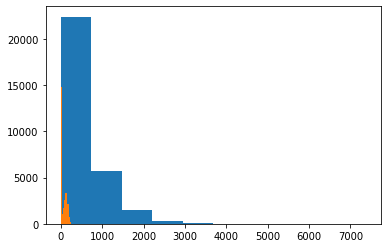

In [82]:
plt.hist(s_mobile_rep.mou)
plt.hist(s_mobile_rep.overage)


Professionals tend to have a mean of 420 minutes on calls

In [83]:
s_mobile_rep.mou.mean()

540.7670666666667

In [84]:
s_mobile_rep.overage.mean()

61.7234

Professionals tend to go around 50 minutes of overage

In [85]:
test_overage = s_mobile_rep['overage'].mean()
test_overage

61.7234

In [86]:
s_mobile_rep.groupby('occupation').overage.std()

occupation
other           68.864750
professional    63.595877
student         66.268290
retired         67.243969
Name: overage, dtype: float64

In [87]:
s_mobile_rep[s_mobile_rep.overage > 50].groupby('occupation').churn_yes.mean()

occupation
other           0.019951
professional    0.031746
student         0.049268
retired         0.003603
Name: churn_yes, dtype: float64

In [88]:
s_mobile_rep[s_mobile_rep.mou > 500].groupby('occupation').churn_yes.mean()

occupation
other           0.015473
professional    0.025896
student         0.040000
retired         0.005151
Name: churn_yes, dtype: float64

### Plan is to extend a promotion to students that extends their minutes leading to less overage charges and therefore reduce churn
by extending the minutes offered to students and professionals we are expecting see less overage and therefore reduce churn. we are assuming that once the promotion is sent which will extend the minutes used that will cover their mean overage and reduce their overage to zero or near zero

In [89]:
#if else statemnet to only give 0 in overage to students and keep overages as is for the rest of the professions
s_mobile_rep['occupation_id'] = np.where(s_mobile_rep['occupation']=='student', 's', "o")

s_mobile_rep['overage_test'] = np.where(s_mobile_rep['occupation_id'] == 's', 0, s_mobile_rep['overage'])
                                    
s_mobile_rep['overage'] = s_mobile_rep['overage_test']               


In [91]:
s_mobile_rep["p_redoverage"] = lr1.predict(
    s_mobile_rep[s_mobile_rep.representative == 1]
)
#s_mobile_rep.loc[s_mobile_rep.overage > 50, ["churn_yes", "p_redooverage"]].agg(
   # ["count", "mean"]
#).round(4)
s_mobile_rep

,customer,churn,changer,changem,revenue,mou,overage,roam,conference,months,...,training,representative,churn_yes,cweight,pred_lr1,p_uniqsMin,p_retcalls_promotion,occupation_id,overage_test,p_redoverage
2,U47928407,no,0,-9,39,1158,96,0,1,9,...,NaN,1,0,49,0.019963,0.019963,0.019963,o,96,0.019963
4,U41010771,no,-2,-8,100,1888,112,9,0,20,...,NaN,1,0,49,0.010046,0.009200,0.010046,o,112,0.010046
5,U18263157,no,-2,-7,45,504,73,2,0,11,...,NaN,1,0,49,0.019982,0.019982,0.019982,o,73,0.019982
7,U18798421,no,96,38,60,777,133,0,1,7,...,NaN,1,0,49,0.009729,0.009729,0.009729,o,133,0.009729
10,U30117312,no,1,126,30,19,0,0,0,13,...,NaN,1,0,49,0.007738,0.007738,0.007738,o,0,0.007738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68985,U88554636,no,0,-4,50,630,0,0,0,28,...,NaN,1,0,49,0.019775,0.019582,0.019775,s,0,0.019775
68988,U68703099,no,0,-3,61,97,0,0,0,10,...,NaN,1,0,49,0.017479,0.017309,0.017479,o,0,0.017479
68991,U19865602,no,0,-8,33,322,0,0,0,16,...,NaN,1,0,49,0.033945,0.031452,0.033945,o,0,0.033945
68995,U97081813,no,0,-15,33,49,0,0,0,19,...,NaN,1,0,49,0.018219,0.018219,0.018219,o,0,0.018219


In [92]:
s_mobile_rep.loc[s_mobile_rep.overage > 50, ["churn_yes", "p_redoverage"]].agg(
    ["count", "mean"]
).round(4)


,churn_yes,p_redoverage
count,13445.0000,13445.0000
mean,0.0194,0.0219


In [93]:
months = np.arange(1,61)
discount = 0.1
mdiscount = (1+discount)**(1/12)-1

In [108]:
#typical churn from above 
churn = pd.Series([0.0493]*60)
#what is the average revenue of an individual with a greater overage
avg_revenue = s_mobile_rep[s_mobile_rep.overage > 50].revenue.mean()
prob_active = list((1-churn).cumprod())
prob_active.insert(0, 1)

In [109]:
prob_active = prob_active[:-1]

In [110]:
expected_profit = np.array(([avg_revenue - 20]*60))*np.array(prob_active)


In [111]:
pv_expected_profit = expected_profit/np.power(1+mdiscount,months)
clv = pv_expected_profit.cumsum()
clv

array([ 53.00713884, 103.00235686, 150.15679451, 194.63186791,
       236.57982132, 276.14424832, 313.46058339, 348.65656542,
       381.85267511, 413.16254727, 442.69335988, 470.54620097,
       496.81641462, 521.59392737, 544.96355604, 567.00529807,
       587.79460536, 607.40264256, 625.89653067, 643.33957679,
       659.79149087, 675.30859005, 689.9439915 , 703.74779419,
       716.76725044, 729.04692763, 740.62886077, 751.55269641,
       761.85582833, 771.57352556, 780.73905312, 789.38378585,
       797.53731587, 805.22755382, 812.48082444, 819.32195667,
       825.77436864, 831.86014784, 837.60012674, 843.01395405,
       848.12016206, 852.93623   , 857.47864396, 861.76295322,
       865.80382357, 869.61508745, 873.20979135, 876.60024044,
       879.79804067, 882.81413857, 885.65885864, 888.34193875,
       890.87256346, 893.25939544, 895.51060514, 897.63389875,
       899.63654462, 901.52539806, 903.30692488, 904.98722349])

### Check after promotion is offered

In [104]:
churn = pd.Series([0.0255]*60)
#what is the average revenue of an individual with a phone greater than eqpdays
avg_revenue = s_mobile_rep[s_mobile_rep.overage < 50].revenue.mean()
prob_active = list((1-churn).cumprod())
prob_active.insert(0, 1)

In [105]:
prob_active = prob_active[:-1]

In [106]:
expected_profit = np.array(([avg_revenue - 20]*60))*np.array(prob_active)

In [107]:
pv_expected_profit = expected_profit/np.power(1+mdiscount,months)
clv = pv_expected_profit.cumsum()
clv

array([ 22.81211258,  44.86665031,  66.18877174,  86.80279992,
       106.73225014, 125.99985678, 144.62759922, 162.63672692,
       180.04778364, 196.88063093, 213.15447073, 228.8878673 ,
       244.0987684 , 258.80452575, 273.02191483, 286.76715401,
       300.05592309, 312.90338112, 325.32418375, 337.33249991,
       348.942028  , 360.16601151, 371.0172541 , 381.50813426,
       391.65061937, 401.4562794 , 410.93630008, 420.10149568,
       428.96232132, 437.52888493, 445.81095875, 453.81799049,
       461.55911411, 469.04316025, 476.27866626, 483.27388601,
       490.03679924, 496.57512069, 502.89630889, 509.00757471,
       514.91588951, 520.62799317, 526.15040173, 531.48941483,
       536.65112291, 541.64141415, 546.46598119, 551.13032761,
       555.63977424, 559.99946519, 564.21437376, 568.28930805,
       572.22891653, 576.03769327, 579.71998311, 583.27998659,
       586.72176476, 590.0492438 , 593.26621951, 596.37636163])

The idea was that we could target individuals who had a history of using overage minutes and upgrade them to some sort of unlimited plan. It is known that overage minutes can get very pricey and potentially we could find a balance that would be profitable to S-Mobile while being appealing to the customer to have them stay on as an S-Mobile customer. With these CLV calculations, it doesn't look like we will be taking this approach as our CLV decreased.

## UniqSubs Analysis

#### Aneeta

In [113]:
s_mobile_rep.groupby('uniqsubs').churn_yes.mean()

uniqsubs
1     0.018885
2     0.020653
3     0.022678
4     0.029455
5     0.017316
6     0.082192
7     0.043478
8     0.000000
9     0.250000
10    0.000000
11    0.000000
12    0.000000
Name: churn_yes, dtype: float64

By studying the impact of uniqsubs on the churn, average churn increase drastically when the account has more than 5 individuals. With 5 individuals on the account, churn rate is close to the average churn rate of 2%. If we offer a group promotion for these accounts with more than 5 individuals, we could reduce the churn rate.

In [114]:
s_mobile_rep["p_uniqsMin"] = lr1.predict(
    s_mobile[s_mobile.representative == 1].assign(uniqsubs=1)
)
s_mobile_rep.loc[s_mobile_rep.uniqsubs >5, ["churn_yes", "p_uniqsMin"]].agg(
    ["count", "mean"]
).round(4)

,churn_yes,p_uniqsMin
count,111.0000,111.0000
mean,0.0721,0.0218


In [118]:
## CLV BEFORE 

#typical churn from above 
churn = pd.Series([.0721]*60)
avg_revenue = s_mobile_rep[s_mobile_rep.uniqsubs >5].revenue.mean()
prob_active = list((1-churn).cumprod())
prob_active.insert(0, 1)
prob_active = prob_active[:-1]

In [119]:
expected_profit = np.array(([avg_revenue - 20]*60))*np.array(prob_active)
pv_expected_profit = expected_profit/np.power(1+mdiscount,months)
clv = pv_expected_profit.cumsum()
clv

array([ 37.65469116,  72.31806845, 104.22776384, 133.60253168,
       160.64374829, 185.53679255, 208.45231672, 229.54741631,
       248.96670706, 266.84331636, 283.29979585, 298.44896159,
       312.39466747, 325.23251714, 337.05051943, 347.92969172,
       357.94461527, 367.16394659, 375.65088806, 383.46362123,
       390.65570563, 397.27644604, 403.3712304 , 408.98184101,
       414.14674096, 418.9013378 , 423.27822628, 427.30741181,
       431.01651615, 434.43096675, 437.57417112, 440.46767722,
       443.13132127, 445.58336364, 447.84061413, 449.91854713,
       451.83140774, 453.59230943, 455.2133239 , 456.7055639 ,
       458.07925936, 459.34382753, 460.50793756, 461.5795699 ,
       462.56607106, 463.4742039 , 464.31019407, 465.07977261,
       465.78821532, 466.44037887, 467.04073411, 467.59339673,
       468.10215545, 468.57049805, 469.00163519, 469.39852252,
       469.76388084, 470.10021486, 470.40983028, 470.69484964])

In [120]:
## CLV AFTER 

#typical churn from above 
churn = pd.Series([.0218]*60)
avg_revenue = s_mobile_rep[s_mobile_rep.uniqsubs >5].revenue.mean()
prob_active = list((1-churn).cumprod())
prob_active.insert(0, 1)
prob_active = prob_active[:-1]

In [121]:
expected_profit = np.array(([avg_revenue - 20]*60))*np.array(prob_active)
pv_expected_profit = expected_profit/np.power(1+mdiscount,months)
clv = pv_expected_profit.cumsum()
clv

array([  37.65469116,   74.19711563,  109.6601282 ,  144.07561319,
        177.47451309,  209.88685639,  241.34178459,  271.8675784 ,
        301.49168312,  330.2407334 ,  358.14057711,  385.21629863,
        411.49224135,  436.99202964,  461.73858999,  485.7541717 ,
        509.06036686,  531.67812975,  553.62779569,  574.92909932,
        595.60119236,  615.66266081,  635.13154166,  654.0253391 ,
        672.36104031,  690.15513066,  707.42360857,  724.18199989,
        740.44537188,  756.22834669,  771.5451146 ,  786.40944669,
        800.83470729,  814.83386595,  828.41950913,  841.60385149,
        854.39874689,  866.81569906,  878.86587189,  890.56009954,
        901.90889614,  912.92246522,  923.61070894,  933.98323695,
        944.04937505,  953.81817357,  963.2984155 ,  972.4986244 ,
        981.42707205,  990.09178589,  998.50055626, 1006.66094336,
       1014.58028409, 1022.26569862, 1029.72409679, 1036.96218436,
       1043.98646898, 1050.80326611, 1057.41870462, 1063.83873

In [122]:
1063.83873237-470.69484964

593.1438827299999

It seems if we can incentivize individuals with uniqsubs > 5 to split up their plan into a single plan, we can increase CLV by 593 dollars. Perhaps we could offer each customer on that 'family' plan an 100 dollar credit to open up their own account at S-Mobile. We will gain additional customers this way while also decreasing churn on these existing members.

## Conclusion

While we investigated a number of options to decrease churn at S-Mobile, there were two that stood out.

First, we made a number of assumptions when calculating CLV. First, we determined S-Mobile to be a high-fixed cost business. This means that we believe S-Mobile does not have a high number of variable costs, instead they have spend a significant amount on setting up an infrastructure. Because of this, we assigned a global s-mobile cost of 20 dollars per customer. We also decided to use a 10% yearly discount, which equated to an 8% monthly discount.

With that, here are our offers for S-Mobile:

* Offer to upgrade individuals with equipment greater than 2 years.
We found that these individuals had a much higher churn rate than customers with more current equipment. When customers upgrade their equipment, they are more likely to stay with a cell phone provider for an extended period of time. We found that we can offer customers up to a 900 credit on trade in their old equipment. We made this a policy that would be offered to all S-Mobile customers. This would be a one time expenditure on S-Mobile. 

* Once a customer calls customer retention, offer them a 300 credit.
We found that individuals who called customer retention more than once were at a much higher risk for churn. The analysis we performed showed that if we could make sure a customer doesn't call more than once, we can increase CLV by close to 500 dollars. We suggest starting with a 300 credit to see how this pacifies customers, and if we need to up the credit we can increase it up to 500 dollars.